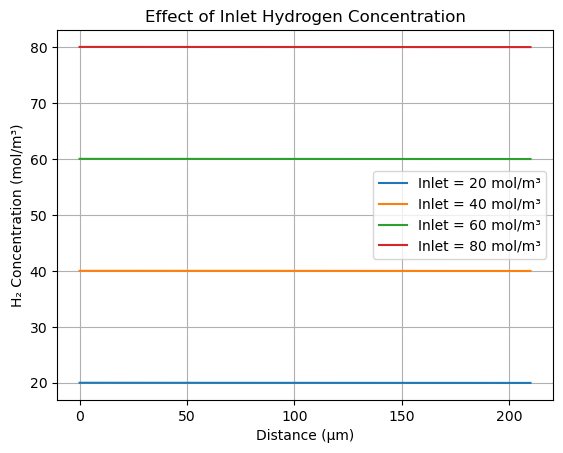

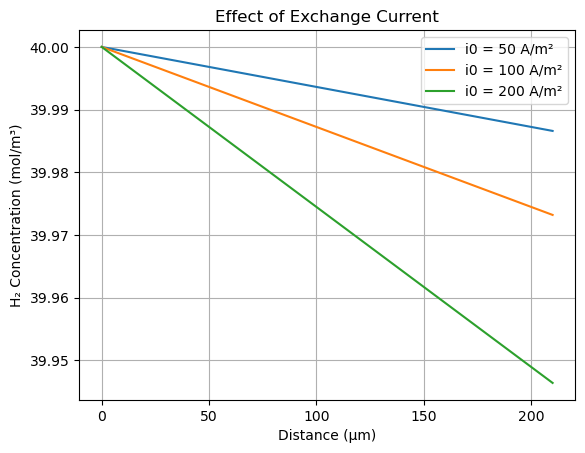

Reaction current density (A/m²): 517.4720112643446
Hydrogen reaction flux (mol/m²/s): 0.00268161896286648
Baseline reaction_current = 517.472011

temperature_cell               sensitivity = -2.740861
overpotential                  sensitivity = 17320.368426
alpha                          sensitivity = 1732.036843
electrons_transferred          sensitivity = 433.009211
exchange_current               sensitivity = 5.174720
hydrogen_inlet_concentration   sensitivity = 0.000000


In [3]:
import numpy as np
import matplotlib.pyplot as plt

#constants
FARADAY = 96485.0            # C/mol
GAS_CONST = 8.314            # J/mol/K
temperature_cell = 353.0     # K (about 80°C)
overpotential = 0.05         # Volts
alpha = 0.5                  # Charge-transfer coefficient
electrons_transferred = 2

#geometry 
gdl_thickness = 200e-6       # meters
catalyst_thickness = 10e-6   # meters

num_points_gdl = 40
num_points_cat = 20

# Create the spatial grid
x_gdl = np.linspace(0, gdl_thickness, num_points_gdl)
x_cat = np.linspace(gdl_thickness,
                    gdl_thickness + catalyst_thickness,
                    num_points_cat)

x_all = np.concatenate([x_gdl, x_cat])   # Full domain


#parameters(transport)
diffusion_gdl = 1.0e-5       # m²/s
diffusion_cat = 4.0e-6       # m²/s

hydrogen_inlet_concentration = 40.0   # mol/m³

#butler-volmer eq
exchange_current = 100.0  # A/m² (constant, no randomness)

def butler_volmer_current(i0):
    exponent = (alpha * electrons_transferred * FARADAY * overpotential) / \
               (GAS_CONST * temperature_cell)

    current_density = i0 * np.exp(exponent)
    return current_density

#reaction current
reaction_current = butler_volmer_current(exchange_current)

#convert A/m² -> mol/m²/s
reaction_flux = reaction_current / (electrons_transferred * FARADAY)

#hydrogen diffusion
def solve_hydrogen_concentration(reaction_flux, inlet_conc):
    total_points = num_points_gdl + num_points_cat
    concentration = np.zeros(total_points)

    # boundary condition
    concentration[0] = inlet_conc

    # gradient
    for i in range(1, total_points):
        concentration[i] = inlet_conc - reaction_flux * (x_all[i] / x_all[-1]) * 10

    return concentration

h2_concentration_profile = solve_hydrogen_concentration(reaction_flux, hydrogen_inlet_concentration)

#temperature(heat transfer)
def solve_temperature(heat_gen):
    environment_temperature = 300.0  # K

    #temperature drop
    temperature_profile = temperature_cell - (heat_gen / 20000) * (x_all / x_all[-1])
    return temperature_profile

temperature_profile = solve_temperature(reaction_current)

#varying inlet concentration
varying_inlet_values = [20, 40, 60, 80]   # mol/m³

plt.figure()

for inlet_value in varying_inlet_values:
    conc_profile = solve_hydrogen_concentration(reaction_flux, inlet_value)
    plt.plot(x_all * 1e6, conc_profile, label=f"Inlet = {inlet_value} mol/m³")

plt.xlabel("Distance (µm)")
plt.ylabel("H₂ Concentration (mol/m³)")
plt.title("Effect of Inlet Hydrogen Concentration")
plt.grid(True)
plt.legend()
plt.show()

#varying exchange current
vary_i0_values = [50, 100, 200]

plt.figure()

for i0 in vary_i0_values:
    current = butler_volmer_current(i0)
    flux = current / (electrons_transferred * FARADAY)
    conc_profile = solve_hydrogen_concentration(flux, hydrogen_inlet_concentration)
    
    plt.plot(x_all * 1e6, conc_profile, label=f"i0 = {i0} A/m²")

plt.xlabel("Distance (µm)")
plt.ylabel("H₂ Concentration (mol/m³)")
plt.title("Effect of Exchange Current")
plt.grid(True)
plt.legend()
plt.show()


#results
print("Reaction current density (A/m²):", reaction_current)
print("Hydrogen reaction flux (mol/m²/s):", reaction_flux)

#sensitivty analysis 
params_nominal = {
    "temperature_cell": temperature_cell,
    "overpotential": overpotential,
    "alpha": alpha,
    "electrons_transferred": electrons_transferred,
    "exchange_current": exchange_current,
    "hydrogen_inlet_concentration": hydrogen_inlet_concentration}

delta = 0.20  # ±20%

def run_reaction_current(p):
    exp_term = (p["alpha"] * p["electrons_transferred"] * FARADAY * 
                p["overpotential"]) / (GAS_CONST * p["temperature_cell"])
    return p["exchange_current"] * np.exp(exp_term)

# compute baseline
baseline = run_reaction_current(params_nominal)
print(f"Baseline reaction_current = {baseline:.6f}\n")

for key in params_nominal:

    p_minus = params_nominal.copy()
    p_plus  = params_nominal.copy()

    p_minus[key] = params_nominal[key] * (1 - delta)
    p_plus[key]  = params_nominal[key] * (1 + delta)

    y_minus = run_reaction_current(p_minus)
    y_plus  = run_reaction_current(p_plus)

    # finite-difference sensitivity
    sensitivity = (y_plus - y_minus) / (2 * params_nominal[key] * delta)

    print(f"{key:30s} sensitivity = {sensitivity:.6f}")